# Project 4 (Sein Chyi)

In [1]:
from bs4 import BeautifulSoup
import urllib
import requests
import pandas as pd
import os
from selenium import webdriver
from time import sleep
from selenium.webdriver.common.keys import Keys
import pyodbc
import datetime
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn.linear_model
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV,ElasticNetCV
from sklearn.linear_model import HuberRegressor,RANSACRegressor,TheilSenRegressor

import xgboost as xgb
from xgboost import plot_importance,XGBClassifier,XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict,StratifiedKFold

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sklearn.metrics
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [2]:
jobs_raw = pd.read_csv('jobs_raw_2019_04_28.csv')
industry_df = pd.read_csv('jobs_industry_v2_2019_05_07.csv')

# reading industry data

jobs_raw = jobs_raw.merge(industry_df,how='left',left_on='url',right_on='url')
jobs_raw.columns

# checking null values in each column

jobs_raw.isnull().sum()

job_id                   0
company                  0
title                    0
location               401
description              0
last_posted_date         0
closing_date             0
seniority               16
employment_type          0
num_of_applications      0
company_info           167
salary_range             0
url                      0
requirement              3
industry                 0
dtype: int64

In [3]:
# Top 20 companies by number of jobs

jobs_raw.groupby('company').agg({"job_id":"count"}).sort_values(by='job_id',ascending=False).head(20)

,job_id
company,
Company Undisclosed,147
DBS BANK LTD.,62
MACHSPEED HUMAN RESOURCES PTE. LTD.,32
KERRY CONSULTING PTE. LTD.,27
GOVERNMENT TECHNOLOGY AGENCY,27
BLUECHIP PLATFORMS ASIA PTE. LTD.,26
OVERSEACHINESE BANKING CORPORATION LIMITED,25
A*STAR RESEARCH ENTITIES,25
NATIONAL UNIVERSITY OF SINGAPORE,20


# Data pre-processing

In [4]:
# identifying job category based on title: ANALYST vs DATA ENGINEER vs DATA SCIENTIST

jobs = jobs_raw.copy()

def data_role_condition(val):
    if 'analy' in val: 
        return 'analyst'
    elif 'data scientist' in val or 'data science' in val or 'machine learn' in val or 'ml' in val or 'ai ' in val: 
        return 'data scientist'
    elif 'data' in val and 'engineer' in val:
        return 'data engineer'
    else: 
        return 'other'

jobs['data_role_category'] = [data_role_condition(val.lower()) for val in jobs['title']]

jobs.groupby('data_role_category').size()

data_role_category
analyst           1218
data engineer      122
data scientist     106
other              316
dtype: int64

In [5]:
# extract SALARY using regex

salary_low = []
salary_high = []
for index,txt in enumerate(jobs['salary_range']):
    try: 
        # extracting minimum expected salary from the range
        salary_low.append(int(re.findall("\d+,\d+", txt)[0].replace(",","")))
    except:
        salary_low.append(None)
        
    try:
        # extracting maximum expected salary from the range
        salary_high.append(int(re.findall("\d+,\d+", txt)[1].replace(",","")))
    except:
        salary_high.append(None)

jobs['salary_low'] = salary_low
jobs['salary_high'] = salary_high

jobs.head()

,job_id,company,title,location,description,last_posted_date,closing_date,seniority,employment_type,num_of_applications,company_info,salary_range,url,requirement,industry,data_role_category,salary_low,salary_high
0,JOB-2019-0089288,IBM SINGAPORE PTE LTD,Finance Analyst,"IBM PLACE, 9 CHANGI BUSINESS PARK CENTRAL 1 48...",The analyst role is responsible for the analys...,Posted 26 Apr 2019,Closing on 26 May 2019,Professional,"Permanent, Full Time",6 applications,"At IBM, we strive to lead in the creation, dev...",", $4,000to$5,500, $4,000, to$5,500, Monthly, ...",https://www.mycareersfuture.sg/job/finance-ana...,4 years Experience in FinanceAccounting Audit...,Information Technology,analyst,4000.0,5500.0
1,JOB-2019-0089172,ROBERT WALTERS (SINGAPORE) PTE LTD,Client Onboarding Analyst,6 BATTERY ROAD 049909,An exciting 6 month Client Onboarding Analyst ...,Posted 26 Apr 2019,Closing on 10 May 2019,Executive,"Temporary, Contract",1 application,ROBERT WALTERS (SINGAPORE) PTE LTD\nRobert Wal...,"Recruiter, , $5,000to$6,000, $5,000, to$6,000...",https://www.mycareersfuture.sg/job/client-onbo...,To succeed in this Client Onboarding environme...,Banking and Finance,analyst,5000.0,6000.0
2,JOB-2019-0088785,DRIVER TRETT (SINGAPORE) PTE. LTD.,Delay Analyst (Consultant Senior Consultant l...,NaN,Driver Trett have a strong presence globally a...,Posted 26 Apr 2019,Closing on 25 May 2019,Professional,Full Time,1 application,"Driver Group Plc is a cutting edge, multidisci...",", $7,500to$14,000, $7,500, to$14,000, Monthly...",https://www.mycareersfuture.sg/job/delay-analy...,Qualifications Requirements Bachelor’s degre...,Consulting,analyst,7500.0,14000.0
3,JOB-2019-0090078,AMAZON ASIAPACIFIC HOLDINGS PRIVATE LIMITED,Senior Finance Analyst,"AIA TOWER, 1 ROBINSON ROAD 048542","At Amazon, were working to be the most custome...",Posted 26 Apr 2019,Closing on 26 May 2019,Manager,Permanent,4 applications,AMAZON ASIAPACIFIC HOLDINGS PRIVATE LIMITED...,", Salary undisclosed, , Closing on 26 May 2019",https://www.mycareersfuture.sg/job/senior-fina...,Create financial modelssensitivities for futur...,Others,analyst,NaN,NaN
4,JOB-2019-0090054,METEORITE INFORMATICS PTE. LTD.,Senior Business Analyst,"VIVA BUSINESS PARK, 750C CHAI CHEE ROAD 469003",Scope of Work for Senior System AnalystTeam Le...,Posted 26 Apr 2019,Closing on 26 May 2019,Professional,Full Time,1 application,METEORITE INFORMATICS(MI) is a Singapore based...,", $5,000to$6,000, $5,000, to$6,000, Monthly, ...",https://www.mycareersfuture.sg/job/senior-busi...,Pre-requisite for Senior System AnalystTeam Le...,Information Technology,analyst,5000.0,6000.0


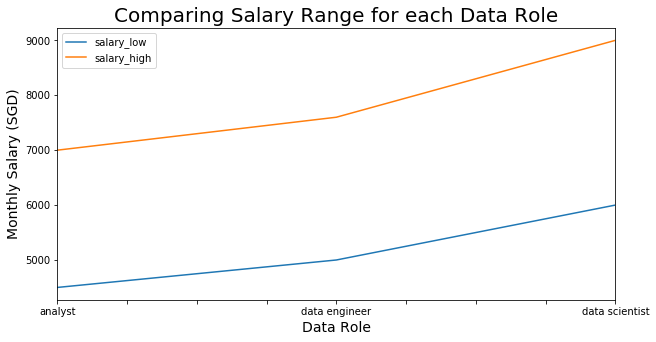

In [6]:
fig,ax = plt.subplots(figsize=(10,5))
jobs[jobs['data_role_category']!='other'].groupby('data_role_category').median()[['salary_low','salary_high']].plot(ax=ax)
plt.title('Comparing Salary Range for each Data Role',fontsize=20)
plt.xlabel('Data Role',fontsize=14)
plt.ylabel('Monthly Salary (SGD)',fontsize=14)
plt.show()

In [7]:
# is it MONTHLY salary or ANNUAL salary posted?

jobs['annual_monthly'] = [re.findall("[A-Za-z]+[ly]", txt)[0] for txt in jobs['salary_range'] ]
jobs['annual_monthly'] = [12 if val == 'Monthly' else (1 if val =='Annually' else None) for val in jobs['annual_monthly'] ]
jobs.groupby('annual_monthly').size()

annual_monthly
1.0       55
12.0    1538
dtype: int64

In [8]:
# convert all to ANNUAL salary

jobs['annual_salary_low'] = jobs['salary_low'].fillna(0).astype('int64',errors='ignore') \
                            * jobs['annual_monthly'].fillna(0).astype('int64',errors='ignore')
jobs['annual_salary_high'] = jobs['salary_high'].fillna(0).astype('int64',errors='ignore') \
                            * jobs['annual_monthly'].fillna(0).astype('int64',errors='ignore')

# dropping job postings with NO SALARY information

jobs.dropna(subset=['annual_salary_low', 'annual_salary_high'],inplace=True)
jobs.drop(jobs[jobs['annual_salary_low']==0].index,inplace=True)
jobs.reset_index(drop=True,inplace=True)
jobs.head()

,job_id,company,title,location,description,last_posted_date,closing_date,seniority,employment_type,num_of_applications,...,salary_range,url,requirement,industry,data_role_category,salary_low,salary_high,annual_monthly,annual_salary_low,annual_salary_high
0,JOB-2019-0089288,IBM SINGAPORE PTE LTD,Finance Analyst,"IBM PLACE, 9 CHANGI BUSINESS PARK CENTRAL 1 48...",The analyst role is responsible for the analys...,Posted 26 Apr 2019,Closing on 26 May 2019,Professional,"Permanent, Full Time",6 applications,...,", $4,000to$5,500, $4,000, to$5,500, Monthly, ...",https://www.mycareersfuture.sg/job/finance-ana...,4 years Experience in FinanceAccounting Audit...,Information Technology,analyst,4000.0,5500.0,12.0,48000,66000
1,JOB-2019-0089172,ROBERT WALTERS (SINGAPORE) PTE LTD,Client Onboarding Analyst,6 BATTERY ROAD 049909,An exciting 6 month Client Onboarding Analyst ...,Posted 26 Apr 2019,Closing on 10 May 2019,Executive,"Temporary, Contract",1 application,...,"Recruiter, , $5,000to$6,000, $5,000, to$6,000...",https://www.mycareersfuture.sg/job/client-onbo...,To succeed in this Client Onboarding environme...,Banking and Finance,analyst,5000.0,6000.0,12.0,60000,72000
2,JOB-2019-0088785,DRIVER TRETT (SINGAPORE) PTE. LTD.,Delay Analyst (Consultant Senior Consultant l...,NaN,Driver Trett have a strong presence globally a...,Posted 26 Apr 2019,Closing on 25 May 2019,Professional,Full Time,1 application,...,", $7,500to$14,000, $7,500, to$14,000, Monthly...",https://www.mycareersfuture.sg/job/delay-analy...,Qualifications Requirements Bachelor’s degre...,Consulting,analyst,7500.0,14000.0,12.0,90000,168000
3,JOB-2019-0090054,METEORITE INFORMATICS PTE. LTD.,Senior Business Analyst,"VIVA BUSINESS PARK, 750C CHAI CHEE ROAD 469003",Scope of Work for Senior System AnalystTeam Le...,Posted 26 Apr 2019,Closing on 26 May 2019,Professional,Full Time,1 application,...,", $5,000to$6,000, $5,000, to$6,000, Monthly, ...",https://www.mycareersfuture.sg/job/senior-busi...,Pre-requisite for Senior System AnalystTeam Le...,Information Technology,analyst,5000.0,6000.0,12.0,60000,72000
4,JOB-2019-0089085,GOOGLE ASIA PACIFIC PTE. LTD.,"Publisher Intelligence Analyst, Online Partner...","MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Company overview Google is not a conventional ...,Posted 26 Apr 2019,Closing on 26 May 2019,Junior Executive,Full Time,1 application,...,", $5,700to$11,400, $5,700, to$11,400, Monthly...",https://www.mycareersfuture.sg/job/publisher-i...,Minimum qualifications - BABS degree or equiva...,Sales / Retail,analyst,5700.0,11400.0,12.0,68400,136800


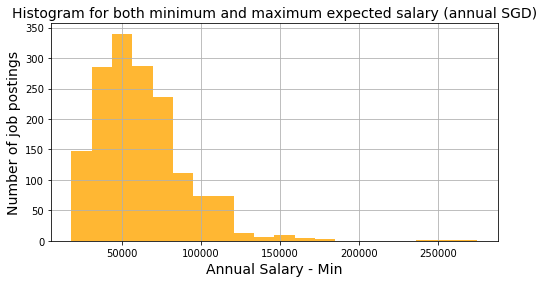

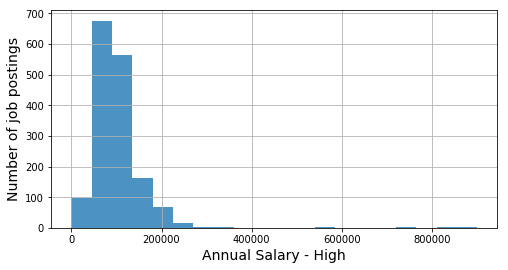

In [9]:
# checking distribution of annual salary

plt.figure(figsize=(8,4))
jobs['annual_salary_low'].hist(bins=20,color='orange',alpha=0.8)
plt.ylabel('Number of job postings',fontsize=14)
plt.xlabel('Annual Salary - Min',fontsize=14)
plt.title('Histogram for both minimum and maximum expected salary (annual SGD)',fontsize=14)
plt.show();

plt.figure(figsize=(8,4))
jobs['annual_salary_high'].hist(bins=20,alpha=0.8)
plt.ylabel('Number of job postings',fontsize=14)
plt.xlabel('Annual Salary - High',fontsize=14)
plt.show();

In [10]:
# excluding outliers

IQR = jobs['annual_salary_low'].quantile(q=0.75) - jobs['annual_salary_low'].quantile(q=0.25) 
jobs = jobs[jobs['annual_salary_low'] <= jobs['annual_salary_low'].quantile(q=0.75) + 1.5*IQR]
jobs.shape

(1517, 21)

In [11]:
# summary of annual salary

jobs[['annual_salary_low','annual_salary_high']].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_salary_low,1517.0,57973.719183,20571.801486,18000.0,42000.0,54996.0,72000.0,114000.0
annual_salary_high,1517.0,92068.369150,52362.703008,21600.0,62400.0,85200.0,108000.0,900000.0


Looking at minimum expected annual salary, we see a median of 55k with a standard deviation of 20k.


In [12]:
# extracting YEAR OF EXPERIENCE required using regex - part 1
def clean_requirement(text):
    return text.replace(" ","").replace("+","")

year_experience_1 = []
year_experience_2 = []
year_experience_3 = []
for index,txt in enumerate(jobs['requirement']):
    try:
        year_experience_1.append(re.search("[0-9]*-[0-9]*year", clean_requirement(txt)).group())
    except:
        year_experience_1.append(None)
        
    try:
        year_experience_2.append(re.search("\w+([a-n])\w+ year", txt).group())
    except:
        year_experience_2.append(None)
        
    try:
        year_experience_3.append(re.search("[0-9]*year", clean_requirement(txt)).group())
    except:
        year_experience_3.append(None)        
    
year_experience_combined = list(zip(year_experience_1,year_experience_2,year_experience_3))
year_experience_combined[:10]

[(None, None, '4year'),
 (None, 'three year', 'year'),
 (None, None, None),
 (None, None, '4year'),
 ('-2year', None, '2year'),
 (None, None, None),
 (None, None, None),
 (None, None, None),
 (None, None, '1year'),
 (None, None, None)]

In [13]:
# extracting year of experience required using regex - part 2

def clean_string_number(x):
    """ Clean up number of years that are written in text format
        for example 'one' --> '1' 
        x is case-insenstive
    """
    if x.lower()=='one': return '1'
    elif x.lower()=='two': return '2'
    elif x.lower()=='three': return '3'
    elif x.lower()=='four': return '4'
    elif x.lower()=='five': return '5'
    elif x.lower()=='six': return '6'
    elif x.lower()=='seven': return '7'
    elif x.lower()=='eight': return '8'
    elif x.lower()=='nine': return '9'
    else: return x

year_experience_clean = []

for values in year_experience_combined:
    if values[0] is not None and values[0].split("-")[0] != '':
        year_experience_clean.append(values[0].split("-")[0])
    elif values[1] is not None:
        year_experience_clean.append(clean_string_number(values[1].replace(" ","").split('year')[0]))
    elif values[2] is not None:
        year_experience_clean.append(values[2].split('year')[0])
    else:
        year_experience_clean.append(None)
list(zip(year_experience_1,year_experience_2,year_experience_3,year_experience_clean))

year_experience_final = []

for val in year_experience_clean:
    try:
        year_experience_final.append(int(val))
    except:
        year_experience_final.append(None)
        
jobs['year_experience_required'] = year_experience_final

# a quick glance on average annual salary (lower boundary) by year of experience
jobs.groupby('year_experience_required').agg({"job_id": "count","annual_salary_low": "mean"})

,job_id,annual_salary_low
year_experience_required,,
0.0,7,53142.857143
1.0,92,41386.956522
2.0,206,46130.427184
3.0,215,58183.051163
4.0,61,64698.163934
5.0,172,65722.674419
6.0,33,78109.090909
7.0,26,78253.384615
8.0,39,78146.153846


In [14]:
# remove YEAR OF EXPERIENCE outlier

np.mean(jobs['year_experience_required']) + 1.5*(np.std(jobs['year_experience_required']))
#10

jobs['year_experience_required'] = [None if val > 15 else val for val in jobs['year_experience_required']]

In [15]:
# summary of minimum experience
pd.DataFrame(jobs['year_experience_required'].describe()).T

# standard deviation = 3
# mean = 2.31

,count,mean,std,min,25%,50%,75%,max
year_experience_required,897.0,3.797101,2.314809,0.0,2.0,3.0,5.0,15.0


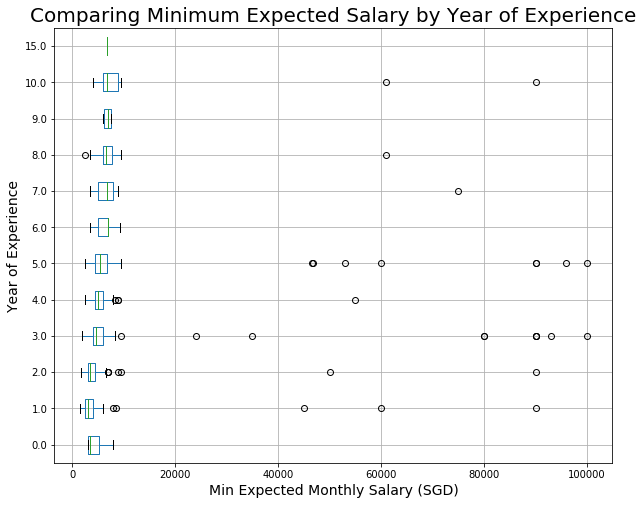

In [16]:
fig,ax = plt.subplots(figsize=(10,8))
jobs.groupby(['job_id','year_experience_required']).mean()['salary_low'].unstack().boxplot(vert=False, ax=ax)
plt.title('Comparing Minimum Expected Salary by Year of Experience',fontsize=20)
plt.ylabel('Year of Experience',fontsize=14)
plt.xlabel('Min Expected Monthly Salary (SGD)',fontsize=14)
plt.show()

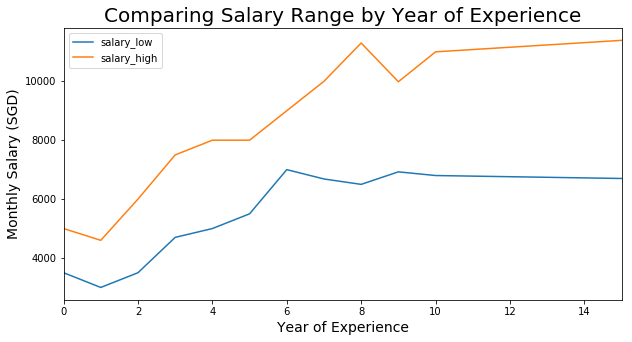

In [17]:
fig,ax = plt.subplots(figsize=(10,5))
jobs.groupby('year_experience_required').median()[['salary_low','salary_high']].plot(ax=ax)
plt.title('Comparing Salary Range by Year of Experience',fontsize=20)
plt.xlabel('Year of Experience',fontsize=14)
plt.ylabel('Monthly Salary (SGD)',fontsize=14)
plt.show()

In [18]:
# clean up year_experience

from sklearn.impute import SimpleImputer
import numpy as np

# fill missing values with median column values

imputed_values = jobs['year_experience_required'].values.reshape(-1,1)
imputer = SimpleImputer(missing_values= np.nan, strategy='median')
jobs['year_experience_required'] = imputer.fit_transform(imputed_values)

# count the number of NaN values in each column
jobs['year_experience_required'].isnull().sum()
jobs.groupby('year_experience_required').size()

year_experience_required
0.0       7
1.0      92
2.0     206
3.0     835
4.0      61
5.0     172
6.0      33
7.0      26
8.0      39
9.0       4
10.0     41
15.0      1
dtype: int64

In [19]:
# number of technical skills required

jobs['requirement_description'] = jobs['requirement'] + jobs['description'] 
jobs['requirement_description'] = jobs['requirement_description'].fillna("NA")

technical_skill = ['hadoop','spark','python'
                   ,'scala','hive','sql'
                   ,'linux','c++','java'
                   ,'matlab','tableau','power bi'
                   ,'qlik','machine learning','kubernetes'
                   ,'docker','aws','kafka'
                   ,'presto','nlp','azure'
                   ,'map reduce','spss','sas'
                   ,'ecs','mesos','big data','software engineer'
                   ,'mongodb','no sql','google cloud'
                    ]

for skill in technical_skill:
    col_name = "skill_{}".format(skill)
    jobs[col_name] = [1 if skill in str(val).lower() else 0 for val in jobs['requirement_description']]

# aggregate total skills required or listed in the job requirement   
jobs['technical_skill_required'] = jobs[[col for col in jobs.columns if 'skill_' in col]].sum(axis=1)
jobs.groupby('technical_skill_required').agg({"job_id": "count","annual_salary_low": "mean"})

,job_id,annual_salary_low
technical_skill_required,,
0,654,56022.831804
1,301,57725.063123
2,179,55110.726257
3,129,60106.852713
4,75,61044.853333
5,52,62796.000000
6,26,68669.076923
7,33,65436.363636
8,14,63971.428571


In [20]:
# does the job require PHD?

jobs['require_phd'] = [1 if 'phd' in str(val).replace(".","").lower() else 0 for val in jobs['requirement_description']]
jobs.groupby('require_phd').size()

require_phd
0    1418
1      99
dtype: int64

In [21]:
# clean up INDUSTRY
jobs['industry'] = jobs['industry'].apply(lambda x:str(x).replace(" ","")).replace(",","")

# RUN THE FOLLOWING CODE ONLY ONCE!!! 
# beware of duplicate columns if you run it multiple times
# comment it out after running it once

jobs = jobs.merge(jobs["industry"].str.get_dummies(sep=','),how='left'
             ,left_on=None,right_on=None,left_index=True,right_index=True)


In [22]:
# investigate average pay for each industry

industry_col = [col for col in jobs["industry"].str.get_dummies(sep=',').columns if 'nan' not in col] 

industry_mean_pay = []
for val in industry_col:
    industry_mean_pay.append((val, round(jobs[jobs[val] ==1]['salary_low'].mean()),jobs[jobs[val] ==1]['job_id'].count()))

pd.DataFrame(industry_mean_pay).sort_values(by=2,ascending=False)

,0,1,2
16,InformationTechnology,6761,854
22,Others,7585,83
0,Accounting/Auditing/Taxation,4541,77
7,Engineering,4730,74
4,Consulting,11798,70
29,Sciences/Laboratory/R&D,4409,53
24,Public/CivilService,4726,39
19,Logistics/SupplyChain,4144,28
2,Advertising/Media,7837,19
31,Telecommunications,4076,17


In [23]:
# clean up SENIORITY

jobs["seniority"]=jobs["seniority"].apply(lambda x:str(x).replace(" ",""))

# split seniority that containts multiple values and dummify
# when running the following code - beware of duplicate columns if you run it multiple times
# comment it out after running it once

jobs = jobs.merge(jobs["seniority"].str.get_dummies(sep=','),how='left'
            ,left_on=None,right_on=None,left_index=True,right_index=True)
jobs.drop(columns=['nan'],inplace=True)

# clean up employment_type

jobs["employment_type"] = jobs["employment_type"].apply(lambda x:str(x).replace(" ",""))

# # RUN THE FOLLOWING CODE ONLY ONCE!!! 
# beware of duplicate columns if you run it multiple times
# comment it out after running it once

jobs = jobs.merge(jobs["employment_type"].str.get_dummies(sep=','),how='left'
            ,left_on=None,right_on=None,left_index=True,right_index=True)

In [24]:
# investigate average pay for each seniority level

seniority_col = [col for col in jobs["seniority"].str.get_dummies(sep=',').columns if 'nan' not in col] 

for val in seniority_col:
    print(val+": SGD "+str(round(jobs[jobs[val] ==1]['salary_low'].mean())))

Executive: SGD 5058
Fresh/entrylevel: SGD 7977
JuniorExecutive: SGD 6953
Manager: SGD 7700
MiddleManagement: SGD 6643
Non-executive: SGD 5682
Professional: SGD 8362
SeniorExecutive: SGD 8243
SeniorManagement: SGD 6227


In [25]:
# NLP job requirement and company description 

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob, Word

# run the following code if this is your first time running this
# import nltk
# nltk.download('averaged_perceptron_tagger')


stop = stopwords.words('english')
stop += ['experience','skill','data','is','are','be','degree','skills'
         ,'year','years','e g','relevant','minimum','ability','good','strong'
        ,'work','knowledge','support','much','days','related','welcome'
        ,'excellent','responsibilities','go','well','using','key'
        ,'across','based','etc','job','closely','singapore','also','use'
        ,'candidate','best','part','make','create','large','ensure','www','com','sg'
        ,'company','industry','description','location','requirement']

count_vect = CountVectorizer(min_df=50,stop_words=stop,ngram_range=(2,3)
                      ,strip_accents='unicode'
                      ,binary=True)

X_nlp    =  count_vect.fit_transform(jobs['requirement_description'])

keywords = pd.DataFrame(X_nlp.todense(),columns=count_vect.get_feature_names())
keywords_column = list(keywords.columns)

jobs = jobs.merge(keywords,how='left',left_on=None,right_on=None,left_index=True,right_index=True)
jobs[keywords_column] = jobs[keywords_column].fillna(0)

# Prediction

In [26]:
# PREDICTOR columns

main_column = ['year_experience_required'
                ,'require_phd'
                ,'data_role_category'
              ,'company']

skill_column = [col for col in jobs.columns if 'skill' in col]

seniority_column = ['Executive',
       'Fresh/entrylevel', 'JuniorExecutive', 'Manager', 'MiddleManagement',
       'Non-executive', 'Professional', 'SeniorExecutive', 'SeniorManagement']

employment_type_column = ['Contract', 'Flexiwork', 'Freelance', 'FullTime', 'Internship',
       'PartTime', 'Permanent', 'Temporary']

industry_columns = list(jobs["industry"].str.get_dummies(sep=',').columns)


predictor_column = main_column + skill_column + seniority_column + employment_type_column + keywords_column +industry_columns
# pd.DataFrame(jobs[predictor_column].isnull().sum()).sort_values(by=0,ascending=False)

In [27]:
# transforming and standardizing the data

X = jobs[predictor_column]

Xd = pd.get_dummies(X)
y = jobs['annual_salary_low']
Xd.drop(columns=['data_role_category_other'],inplace=True)
ss = StandardScaler()

# be careful when transforming array back to data frame, especially there is a missing index with the source data
Xs = pd.DataFrame(ss.fit_transform(Xd),index=Xd.index)
Xs.columns = Xd.columns

Xs_train,Xs_test,y_train,y_test = train_test_split(Xs,y,test_size=0.33,random_state=42)

print(Xs_train.shape,y_train.shape,Xs_test.shape,y_test.shape)
print("Average annual salary: SGD" + str(y.mean()))
print(Xs.columns)

(1016, 813) (1016,) (501, 813) (501,)
Average annual salary: SGD57973.71918259723
Index(['year_experience_required', 'require_phd', 'skill_hadoop',
       'skill_spark', 'skill_python', 'skill_scala', 'skill_hive', 'skill_sql',
       'skill_linux', 'skill_c++',
       ...
       'company_XYPHER PTE. LTD.', 'company_YHS (SINGAPORE) PTE LTD',
       'company_ZALORA SOUTH EAST ASIA PTE. LTD.',
       'company_ZAVE TECHNOLOGY PTE. LTD.', 'company_ZEEMART  PTE. LTD.',
       'company_ZENDESK SINGAPORE PTE. LTD.', 'company_ZENIKA PTE. LTD.',
       'company_ZENITH INFOTECH (S) PTE LTD.', 'company_ZILINGO PTE. LTD.',
       'company_ZOOLOO INFORMATION SYSTEMS PTE. LTD.'],
      dtype='object', length=813)


C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Simple models as base models

## Linear and Lasso

In [28]:
# BASE MODEL

linreg = LinearRegression()
linreg.fit(Xs_train,np.ravel(y_train))
linreg_scores = cross_val_score(linreg, Xs_train,np.ravel(y_train),cv=5,scoring='neg_median_absolute_error')
print(linreg_scores)
print(np.mean(linreg_scores))

[-28218.   -23108.   -29551.   -24187.75 -20872.  ]
-25187.35


In [29]:
# REGULARIZATION - LASSO

lasso = LassoCV(cv=5)
lasso.fit(Xs_train,y_train)
lasso_scores = cross_val_score(lasso,Xs_train,y_train,cv=5,scoring='neg_median_absolute_error')
print(lasso_scores)
print(np.mean(lasso_scores))

[-10941.94488965 -10697.19271698 -11069.44924351  -8923.19556224
 -10160.85352163]
-10358.527186803312


In [30]:
lasso_coefs = pd.DataFrame({'variable':Xs_train.columns,'coef':lasso.coef_,'abs_coef':np.abs(lasso.coef_)})
lasso_coefs[lasso_coefs['abs_coef']>0].sort_values('abs_coef',ascending=False).head(20)

,variable,coef,abs_coef
0,year_experience_required,6453.988949,6453.988949
36,JuniorExecutive,-3506.467661,3506.467661
35,Fresh/entrylevel,-2857.223164,2857.223164
733,company_TANGSPAC CONSULTING PTE LTD,2353.302203,2353.302203
34,Executive,-1979.422327,1979.422327
309,company_BARCLAYS BANK PLC,1617.774137,1617.774137
553,company_MACHSPEED HUMAN RESOURCES PTE. LTD.,-1604.623662,1604.623662
544,company_LAZADA SOUTH EAST ASIA PTE. LTD.,1588.285446,1588.285446
770,company_TWITTER ASIA PACIFIC PTE. LTD.,1578.898782,1578.898782
386,company_DBS BANK LTD.,-1469.878413,1469.878413


Looking at an average pay of 57k across all job postings, we are seeing of 6% increase in minimum expected salary with the increasing relevant year of experience.

Note: standard deviation of year_experience = 1.8

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Lasso Prediction')

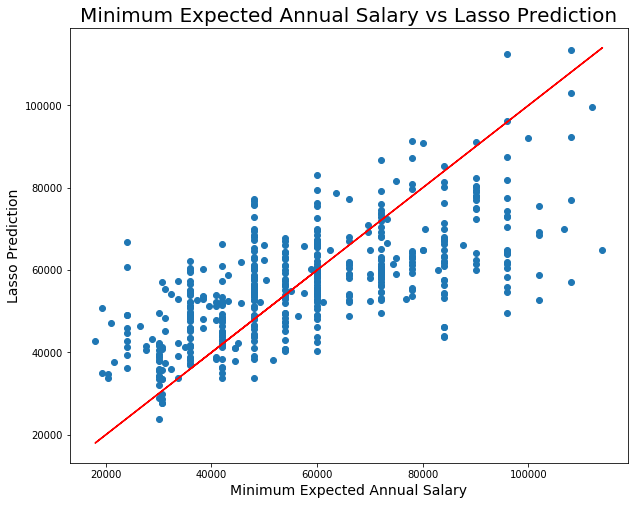

In [31]:
Xs_test['annual_predict_low_lasso'] = lasso.predict(Xs_test[Xs_train.columns])
plt.figure(figsize=(10,8))
plt.scatter(y_test,Xs_test['annual_predict_low_lasso'])
plt.plot(y_test,y_test,color='red')
plt.title('Minimum Expected Annual Salary vs Lasso Prediction',fontsize=20)
plt.xlabel('Minimum Expected Annual Salary',fontsize=14)
plt.ylabel('Lasso Prediction',fontsize=14)

In [32]:
print("Median absolute error = ",sklearn.metrics.median_absolute_error(y_test, Xs_test['annual_predict_low_lasso']))
print("Mean absolute error = ",sklearn.metrics.mean_absolute_error(y_test, Xs_test['annual_predict_low_lasso']))

Median absolute error =  10112.269034768877
Mean absolute error =  11834.851715239673


Lasso prediction: An average of 10k error in estimation across all annual salary predictions.

## xgboost regressor with gridsearch

In [33]:
# #Try GridSearch on XGBoost regressor

# from xgboost.sklearn import XGBRegressor
# xg_reg_gs = XGBRegressor()

# import time
# start_time = time.time()

# from sklearn.model_selection import GridSearchCV

# param_grid = {'base_score':[0.4],
#               'max_depth': [5,7,9],
# #               'reg_alpha': [0,0.5,1],
# #               'reg_lambda': [0,0.5,1],
# #               'min_child_weight': [1, 5, 10],
#               'learning_rate':[0.1,0.2,0.3],
#               'colsample_bytree':[0.3,0.5,0.7],
#               'colsample_bylevel':[0.3,0.5,0.7],
#               'booster':['gbtree'],
#               'n_estimators' : [100,200,500]
#              }

# grid = GridSearchCV(xg_reg_gs, param_grid, cv=3, n_jobs=-1,scoring='neg_median_absolute_error')
# grid.fit(Xs_train,y_train)

# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)
# print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
xg_reg = XGBRegressor(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

# XGBRegressor(base_score=0.4, booster='gbtree', colsample_bylevel=0.7,
#        colsample_bytree=0.5, gamma=0, importance_type='gain',
#        learning_rate=0.1, max_delta_step=0, max_depth=9,
#        min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
#        nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
#        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
#        subsample=1)

xg_reg.fit(Xs_train,y_train)
Xs_test['xgreg_predictions'] = xg_reg.predict(Xs_test[Xs_train.columns])

print("Median absolute error = ",sklearn.metrics.median_absolute_error(y_test, Xs_test['xgreg_predictions']))
print("Mean absolute error = ",sklearn.metrics.mean_absolute_error(y_test, Xs_test['xgreg_predictions']))

C:\Users\swoo\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Median absolute error =  9467.50390625
Mean absolute error =  11813.28423621507


C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


XGBoostRegressor prediction: 

An average of SGD 9k error in estimation across all annual salary predictions.

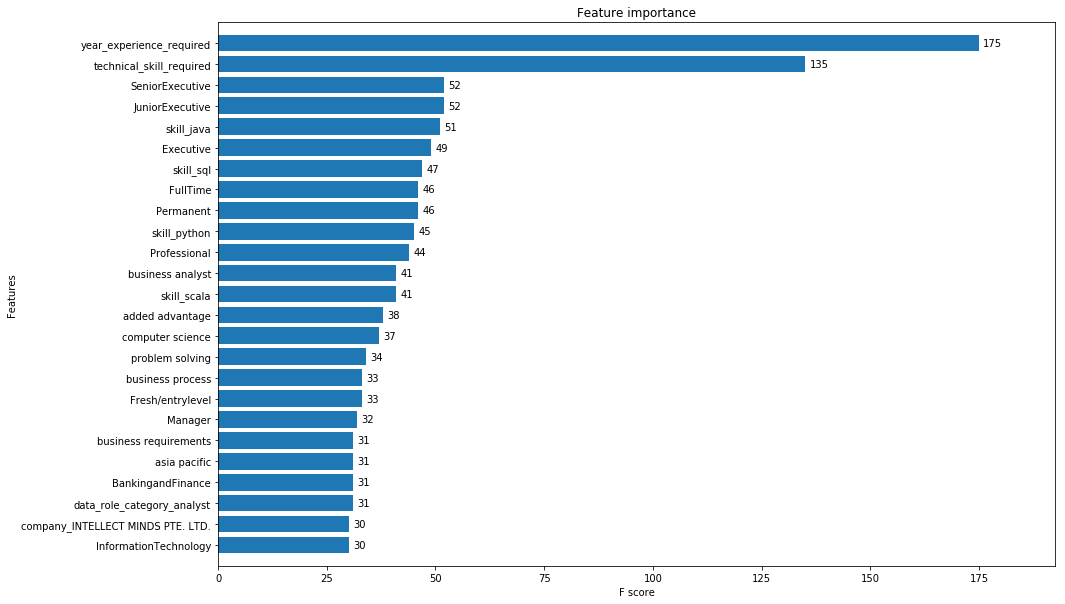

In [35]:
# investigate significant features in impacting salary

fig, ax = plt.subplots(figsize=(15, 10))
plot_importance(xg_reg,max_num_features=25,height=0.8,grid=False,ax=ax );


Text(0.5, 1.0, 'error percentage by annual salary bin')

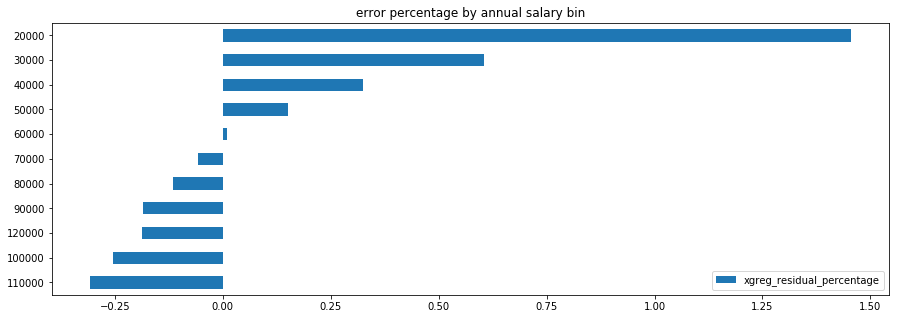

In [36]:
import math                           
def roundup(x):
    return int(math.ceil(x / 10000.0)) * 10000

df = Xs_test.merge(y_test,how='left',left_on=None,right_on=None,left_index=True,right_index=True)
df.head()
df['xgreg_residual_percentage'] = (df['xgreg_predictions'] - df['annual_salary_low']) / df['annual_salary_low']
over_under = ['over' if val > 0 else 0 for val in df['xgreg_residual_percentage']]
fig, ax=plt.subplots(figsize=(15,5))
pd.DataFrame(df.groupby([roundup(val) for val in df['annual_salary_low']])\
    .agg({"xgreg_residual_percentage":"mean"})).sort_values(by='xgreg_residual_percentage').plot.barh(ax=ax)
plt.title('error percentage by annual salary bin')

Text(0.5, 1.0, 'Actual vs Predicted salary (xgboost)')

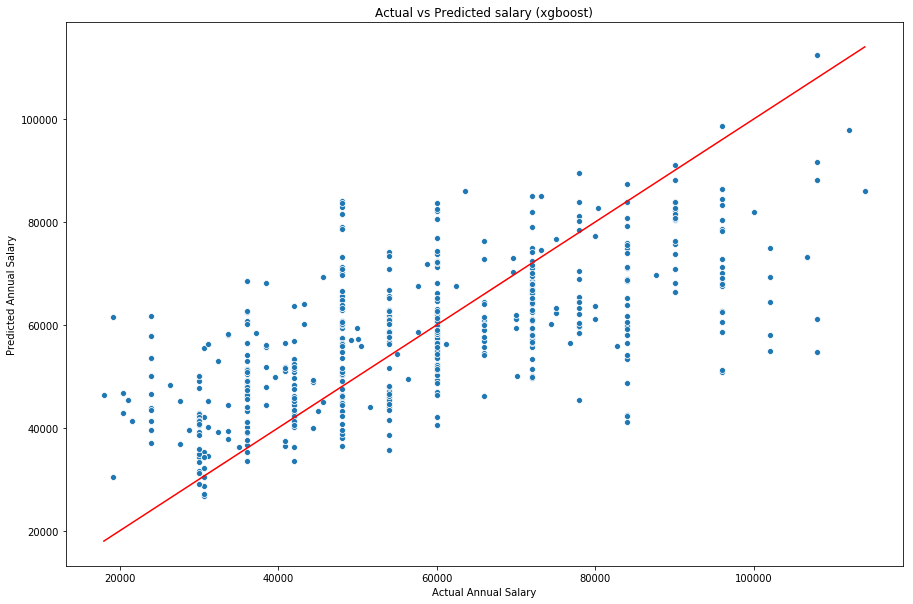

In [37]:
# compare actual salary vs predicted
plt.figure(figsize=(15,10))
sns.scatterplot(y_test,Xs_test['xgreg_predictions'] )
sns.lineplot(y_test,y_test,color='red')

plt.xlabel('Actual Annual Salary')
plt.ylabel('Predicted Annual Salary')
plt.title('Actual vs Predicted salary (xgboost)')


Text(0.5, 1.0, 'Residual Plot')

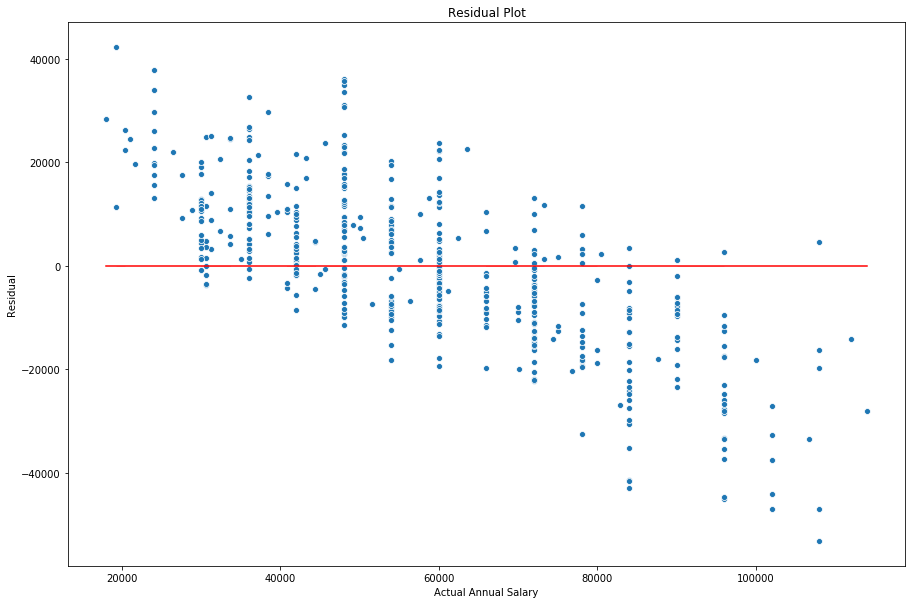

In [38]:
# residual plot

plt.figure(figsize=(15,10))
sns.scatterplot(df['annual_salary_low'],df['xgreg_predictions'] - df['annual_salary_low'])
sns.lineplot(x=df['annual_salary_low'],y=0,color='red')

plt.xlabel('Actual Annual Salary')
plt.ylabel('Residual')
plt.title('Residual Plot')

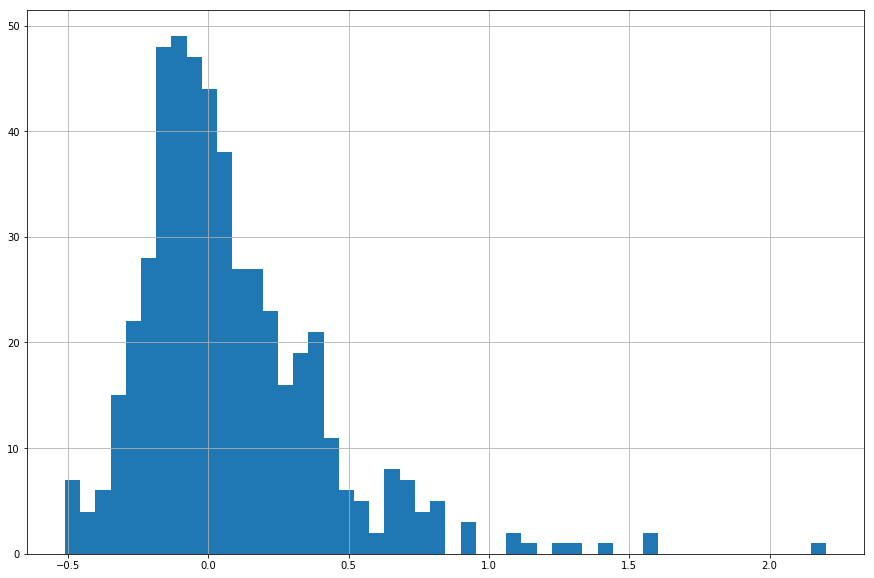

In [39]:
xg_boost_residual = (Xs_test['xgreg_predictions']  - y_test) / y_test
plt.figure(figsize=(15,10))
xg_boost_residual.hist(bins=50)

## Top 5 over-estimated jobs by percentage

In [40]:
Xs_test_temp = Xs_test.merge(y_test,how='left',left_on=None,right_on=None,left_index=True,right_index=True)
Xs_test_temp['residual_percentage'] = (Xs_test_temp['xgreg_predictions'] - Xs_test_temp['annual_salary_low'])/ Xs_test_temp['annual_salary_low']

pd.set_option('max_colwidth', -1)
Xs_test_temp.sort_values(by=['residual_percentage']).tail()\
.merge(jobs[['company','title','requirement','year_experience_required','employment_type','seniority','url']],how='inner',left_on=None,right_on=None,left_index=True,right_index=True)\
[['company','annual_salary_low','xgreg_predictions','title','requirement','employment_type','year_experience_required_y','seniority','url']]

,company,annual_salary_low,xgreg_predictions,title,requirement,employment_type,year_experience_required_y,seniority,url
338,STARHUB LTD.,20400,46690.089844,CSE CS Technical Support Analyst (contract),"• Diploma, GCE “A” ” O” level • Proficient in English and one other language • Customer-driven with ability to build rapport with customers and understand their needs • Able to work in a team within a fast-paced and dynamic environment • Strong negotiating skill in getting payment commitment from customers • Strong team player with initiative and ability to perform under pressure • Strong interpersonal and communication skills • Pleasant, warm and cheerful personality • Strong in mathematical ability • Must be able to work rotating shift duties and during weekends and public holidays * We regret that only shortlisted candidates will be notified.",Contract,3.0,Fresh/entrylevel,https://www.mycareersfuture.sg/job/cse-cs-technical-support-analyst-starhub-bc865ff5b9c679577475a8439beb27f3
1406,DATHENA SCIENCE PTE. LTD.,24000,57882.683594,Field Data Scientist,"Desired Experiences 2+ years of experience in a customerclient-facing role such as Customer Success Manager, Technical Account Manager or Sales Engineer Comfortable managing technical conversations with technical and non-technical stakeholders. Problem-solving skills around technical, product, and business questions. Ability to build great relationships with technical and non-technical customers Contribute to the success of a dynamic and growing organization Good understanding of machine learning techniques and algorithms, such as K-means, k-NN, Naive Bayes, SVM, Decision Forests, etc. Knowledge with common data science toolkits, such as R, Spark, NumPy, etc. Excellence in at least one of these is highly desirable Good knowledge in using query languages such as SQL, Hive, Pig, etc. Knowledge with NoSQL databases, such as Cassandra and HBase Good applied statistics skills, such as distributions, statistical testing, regression, etc. Good scripting and programming skills Python, Scala, Java. Soft Skills Fluent in English Data-oriented personality Exceptional Oral and Written Communication Skills Time management Interpersonal Skills Critical Thinking Presentation Skills Working Conditions The Field Data Scientist must fully embrace the team spirit of a young and innovative Start-up. Travel and working from remote locations may be required. Location Singapore R&D Office.","FullTime,Internship",2.0,Executive,https://www.mycareersfuture.sg/job/field-data-scientist-dathena-science-ef8743c8aad21b7da211bfaf16e59a1e
378,WINSYS TECHNOLOGY PTE LTD,18000,46328.414062,IT Support Analyst,"* Diploma Degree in Computer Science, Computer Engineering or equivalent * Good software development experience in web based applications, Linux and Database (Oracle SQL Server) implementation * Good in Software Application Support, Programming and Database and Network Architecture knowledge. * Strong analytical skills and able to work under tight timelines * Good time keeper, person of integrity * Commitment to quality, attention to detail Interested candidates are to forward your detailed resume stating current and expected salary to recruit@winsys.com.sg We regret that only shortlisted candidates will be notified.",Contract,3.0,Fresh/entrylevel,https://www.mycareersfuture.sg/job/support-analyst-winsys-technology-8e73381a575bc7462fc4211487d118e7
1280,DATHENA SCIENCE PTE. LTD.,24000,61793.625000,Field Operation Engineer Big Data Engineer,"Skills Experience in building and supporting Hadoop BigData architecture including Yarn, HDFS, Hbase, Zookeeper, Phoenix, Spark, Hive, Kafka etc. Ability to isolate and troubleshoot Hadoop service issues using a combination of system and Hadoop logs and monitoringalerting systems. Experience with Apache Ambari. Experienced in Linux (RHEL, CentOS, Ubuntu, Debian, ...) including network and scripting (Bash, Python) Deep understanding of complete end-to-end Data-warehouse Data A

## Top 5 under-estimated jobs by percentage

In [41]:
pd.set_option('max_colwidth', -1)
Xs_test_temp.sort_values(by=['residual_percentage']).head()\
.merge(jobs[['company','title','requirement','year_experience_required','employment_type','seniority','url']],how='inner',left_on=None,right_on=None,left_index=True,right_index=True)\
[['company','annual_salary_low','xgreg_predictions','title','requirement','year_experience_required_y','employment_type','seniority','url']]

,company,annual_salary_low,xgreg_predictions,title,requirement,year_experience_required_y,employment_type,seniority,url
58,DRW SINGAPORE PTE. LTD.,84000,41097.800781,Trading Analyst,"What you’ll do in this role…. Research and analyze trends across major financial markets and cultivate a thorough understanding of current world events and their impact across financial markets Collaborate on the research, development, and implementation of trading strategies Investigate the potential application of existing strategies to new asset classes Perform post-trade analysis of strategies while utilizing custom technology systems Communicate relevant news, market events, and system behaviors to team members What you bring to the team… A bachelor’s, master’s, or PhD in mathematics, statistics, physics, engineering, computer science or related field Recent graduate to 2 years of work experience Advanced quantitative, analytical and problem solving skills and the ability to deploy those skills during time-sensitive situations A deep curiosity of analyzing large data sets using your knowledge of probability and statistics Experience programming in Python, R, C++ or similar languages Proficient in Microsoft Excel, VBA Are adaptive, self-motivated, enjoy challenges and significant responsibility, and thrive in fast-paced, competitive environments Can advocate for your perspectives on trading strategies and risk in a concise manner to the team The ability to communicate effectively and work well in teams",2.0,FullTime,Fresh/entrylevel,https://www.mycareersfuture.sg/job/trading-analyst-drw-singapore-e975d3b300dc9012ad30f8d2570442a8
899,HARTREE PARTNERS SINGAPORE PTE. LIMITED,84000,42349.234375,"Analyst, Job","Backgroun in IT and quantitative finance, experience in energy or commodities is an advantage. Proven experenience (2+ years) in PLEXOS software, to model the Australian Electricity Network. Familiarity with the AEMO EMMS Database schema and ASX schema. Strong knowledge in programming languages such as R.Python, VBA. etc with significant experience in automating data, web scraping and tool creation for the desk. Able to identify and solve problems in an independent manner. 3+ years experience in a similar role andor experience in Australian Power Industry or Markets. Familiar with database technology, preferably Oracle. experience with developing queries, views, functions, and procedures and loadingimporting data (ETL).",2.0,FullTime,JuniorExecutive,https://www.mycareersfuture.sg/job/analyst-job-hartree-partners-singapore-cbdd329da9ef760c1ad8b943ad151bca
1162,OVERSEACHINESE BANKING CORPORATION LIMITED,84000,42526.468750,"Business Analyst Murex, Global Treasury (Business Process Transformation) 2 year contract","Requirements Qualifications • Ideally degree in mathematical or financial discipline. • Familiarity with Treasury products including Fixed Income and FX Cash Money Market as well as derivative products. Good understanding of the trade lifecycle from front to back office. • Experience and in-depth knowledge on Murex Treasury Version 3 platform is required especially in the areas of front office and middle office functions. Knowledge on back office modules is an advantage. • Prior experience in a function of Business Analyst, Project Manager or Middle Back Office Team Lead in conversion projects with a proven track record is preferred. • Excellent communication skills, able to handle multiple projects and priorities concurrently and manage business expectations accordingly. Position 2 year contract",2.0,"Contract,FullTime",SeniorExecutive,https://www.mycareersfuture.sg/job/business-analyst-murex-global-treasury-2-year-contract-oversea-chinese-banking-corporation-b289fb5208bcbc07903ee9e6fc9b06ac
474,BARCLAYS BANK PLC,108000,54778.812500,2019 Markets (Structuring) Graduate Programme,"Our Graduate Roles are available for students in their final year Bachelors or Masters degree students or graduates with no more than 2 working years of expe

## Question 2
### What components of a job posting distinguish data scientists from other data jobs?
### Method 1: EDA

In [42]:
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_nlp.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])
    df =  pd.DataFrame(freq_words).reset_index()
    df.columns =['keyword','frequency']
    return df


In [43]:
for cat in set(jobs['data_role_category']):

    cvt = CountVectorizer(min_df=30,stop_words='english',ngram_range=(2, 3),token_pattern=r'\b\w+\b',strip_accents='unicode')
    X_nlp    =  cvt.fit_transform(jobs[jobs['data_role_category']==cat]['requirement_description'])
    columns  =  np.array(cvt.get_feature_names())   
    
    excluded_keywords = ['experience','skills','data','years','working','degree','e g','years experience']
    freq_words = get_freq_words(X_nlp, columns)
    print(cat)
    print(freq_words[~freq_words['keyword'].isin(excluded_keywords)][:10])
    print('-'*100)

analyst
                  keyword  frequency
0   communication skills   392      
2   business requirements  242      
3   computer science       237      
4   3 years                223      
5   problem solving        222      
6   ability work           209      
7   5 years                208      
9   skills ability         200      
10  business analyst       200      
11  team player            200      
----------------------------------------------------------------------------------------------------
other
                  keyword  frequency
0   communication skills   95       
1   business intelligence  94       
2   business analyst       68       
4   problem solving        66       
5   ability work           58       
6   computer science       56       
7   team members           52       
8   software development   46       
9   interpersonal skills   46       
10  team player            45       
-----------------------------------------------------------------------

### Comparing top keywords of each data role:

#### DATA SCIENTISTS:
1. Machine Learning
2. Data Science
3. Computer Science
4. Big Data  

#### DATA ANALYSTS:
1. Communication skills
2. Business requirements
3. Computer science
4. Problem solving

##### Data scientists requires more of technical skills (hard skills) from the candidate.
##### On the contrary, the hiring manager is emphasizing more of interpersonal skills (soft skills) for data analysts.

### Identify key differences between data analyst vs data scientist/ data engineer from job requirement using k-mean clustering and classification



### Method 2: Un-supervised learning: k-mean clustering
-- identifying key difference of job scope between data scientist vs data engineer vs data analyst

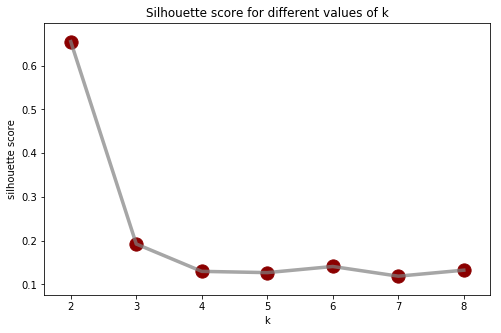

In [44]:
# plotting the silhoutte score for each k to identify a good number of clusters

sils = []
for k in [2,3,4,5,6,7,8]:
    km = cluster.KMeans(n_clusters=k,random_state=99)
    km.fit(jobs[keywords_column])
    sils.append(metrics.silhouette_score(jobs[keywords_column], km.labels_, metric='euclidean'))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot([2,3,4,5,6,7,8], sils, c='grey', lw=3.5, alpha=0.7)
ax.scatter([2,3,4,5,6,7,8], sils, c='darkred', s=175)
plt.title('Silhouette score for different values of k')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.show()

By using Silhouette score, it's suggesting that the optimal clusters from the dataset is 3.

In [45]:
from sklearn import cluster, metrics

k = 3
kmeans = cluster.KMeans(n_clusters=k,random_state=99)
X_cluster = jobs[keywords_column]
kmeans.fit(X_cluster)

# checking silhoutte score between clusters
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
metrics.silhouette_score(X_cluster, labels, metric='euclidean')

0.1923290631583285

The score is positive (though not 1.), indicating that there is decent separation and coherence with 4 clusters.

In [46]:
jobs['kmean_label'] = kmeans.labels_
jobs.groupby('kmean_label').size()

kmean_label
0    412 
1    45  
2    1060
dtype: int64

#### Excluding some keywords and look at top 10 keywords with ngram=(2,3) for each label

In [47]:
# data_role={0:'data scientist/engineer',1:'analyst',2:'other'}

for label in [0,1,2]:

    cvt = CountVectorizer(min_df=10,stop_words='english',ngram_range=(2, 3))
    X_nlp    =  cvt.fit_transform(jobs[jobs['kmean_label']==label]['requirement_description'])
    columns  =  np.array(cvt.get_feature_names())   
    
    excluded_keywords = ['experience','skills','data','years','working','degree','e g','years experience']
    freq_words = get_freq_words(X_nlp, columns)
    
    print("Job Role Category: " + str(label))
    print(" ")
    print(freq_words[~freq_words['keyword'].isin(excluded_keywords)][:10])
    print('-'*100)
    print(" ")

Job Role Category: 0
 
                  keyword  frequency
0   communication skills   173      
2   computer science       113      
3   business requirements  100      
4   business analyst       99       
5   problem solving        94       
6   skills ability         90       
7   ability work           88       
8   working experience     79       
9   team player            78       
10  able work              73       
----------------------------------------------------------------------------------------------------
 
Job Role Category: 1
 
                keyword  frequency
1  communication skills  19       
2  experience working    16       
3  problem solving       14       
4  team player           11       
5  computer science      11       
----------------------------------------------------------------------------------------------------
 
Job Role Category: 2
 
                  keyword  frequency
0   communication skills   347      
2   computer science       296    

There are no clear diferences between 3 clusters found by looking at the keywords from job requirements.

By comparing distribution of the labels with our real distribution of analyst vs data scientist vs data engineers, I assume that label 0 == data scientist, label 1 == others and label 2 == analysts. 
Let's quickly compare the labels against title and check my accuracy:

In [48]:
# Check labels against title

jobs['data_role_category_num'] = [2 if val =='analyst' else (1 if val =='other' else 0) for val in jobs['data_role_category'] ] 
round(1.*len(jobs[ jobs['data_role_category_num'] == jobs['kmean_label']  ])\
/len(jobs['data_role_category_num']),2)


0.5

In [49]:
# check accuracy for each data role
data_role={0:'data scientist/engineer',1:'other',2:'analyst'}
for i in [0,1,2]:
    df_temp_c = jobs[jobs['data_role_category_num']==i] 
    print(i,data_role[i],"|",round(1.*len(df_temp_c[df_temp_c['data_role_category_num']==df_temp_c['kmean_label']])/len(df_temp_c),2))

0 data scientist/engineer | 0.2
1 other | 0.03
2 analyst | 0.67


It seems by using just job requirements and company description, k-mean clustering is unable to accurately help me identifying different job titles.

### Method 3: Supervised-learning: Classification

In [50]:
# exclude Others from data_role_category

jobs_subset = jobs[jobs['data_role_category']!='others']

X_subset = jobs_subset[keywords_column]
y_subset = pd.Series([1 if val =='analyst' else 0 for val in jobs_subset['data_role_category']])
Xsubset_train, Xsubset_test, ysubset_train, ysubset_test = train_test_split(X_subset,y_subset,test_size=0.33,random_state=42)
print(Xsubset_train.shape,ysubset_train.shape,Xsubset_test.shape,ysubset_test.shape)
print("Baseline: ", round(y_subset.value_counts()[1] / len(y_subset),3))

(1016, 162) (1016,) (501, 162) (501,)
Baseline:  0.693


In [51]:
xgb_2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
      colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
      max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
      n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
      reg_alpha=1, reg_lambda=0, scale_pos_weight=1, seed=None,
      silent=True, subsample=1)

kfolds = KFold(n_splits=5,random_state=99)

roc_auc_values =[]
for traini, testi in kfolds.split(Xsubset_train):
    Xsubset_train_ = Xsubset_train.iloc[traini]
    ysubset_train_ = ysubset_train.iloc[traini]
    xgb_2.fit(Xsubset_train_,ysubset_train_)
    y_pred = xgb_2.predict_proba(Xsubset_train.iloc[testi,:])[:,1]
    fpr, tpr, _ = roc_curve(ysubset_train.iloc[testi], y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)
    print(roc_auc)
print("-"*100)
print("mean auc: ",np.mean(roc_auc_values))

0.7280781462971376
0.7193385122410546
0.6522144522144523
0.6862277353689569
0.7112758945386064
----------------------------------------------------------------------------------------------------
mean auc:  0.6994269481320415
